In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !tar -xvzf /content/drive/MyDrive/Sejong.tgz
! unzip /content/drive/MyDrive/airi_dataset.zip

Archive:  /content/drive/MyDrive/airi_dataset.zip
   creating: airi_dataset/
   creating: airi_dataset/test/
  inflating: airi_dataset/metainfo.json  
   creating: airi_dataset/train/
   creating: airi_dataset/val/
   creating: airi_dataset/test/Beach /
   creating: airi_dataset/test/Coworking/
   creating: airi_dataset/test/Grenobl_/
   creating: airi_dataset/test/ArenaEntrance/
   creating: airi_dataset/test/Shamoni/
   creating: airi_dataset/test/IceStadium/
   creating: airi_dataset/test/SochiTorch/
   creating: airi_dataset/test/Stadium/
   creating: airi_dataset/test/LadderNearCoworking/
   creating: airi_dataset/test/Nagano/
   creating: airi_dataset/test/ArenaOutdoor/
   creating: airi_dataset/test/EntranceLadder/
   creating: airi_dataset/test/SportComplex/
   creating: airi_dataset/test/Oslo/
   creating: airi_dataset/test/Milan /
   creating: airi_dataset/test/OmegaHotel/
   creating: airi_dataset/test/Cafeteria/
   creating: airi_dataset/test/Sochi/
   creating: airi_datase

In [3]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 181 kB 60.6 MB/s 
     |████████████████████████████████| 146 kB 62.0 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=db1a55a0e1412142075e253bf346ac3363a86ed6f7492960ee568a998575f11b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.autograd import Variable
from torchvision.models import resnet18

# from keras.preprocessing import image

import PIL
import torch
import torchvision

import matplotlib.pyplot as plt
from sklearn import metrics
import wandb
import tqdm
import json

RANDOM_SEED = 777

torch.manual_seed(RANDOM_SEED)

with open('airi_dataset/metainfo.json') as fin:
    metainfo = json.load(fin)

num_to_class = metainfo['num_to_class']

train_size = metainfo['data']['train_size']
test_size = metainfo['data']['test_size']
val_size = metainfo['data']['val_size']

classes_count = len(num_to_class)

class_count = metainfo['data']['class_count']

In [5]:
from PIL import Image
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import torchvision.transforms.functional as Function
from IPython.display import display
from time import time
from matplotlib import offsetbox
from sklearn.neighbors import DistanceMetric
%matplotlib inline

## NetVLAD

In [6]:
class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, num_clusters=6, dim=128, alpha=100.0,
                 normalize_input=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=True)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self._init_params()

    def _init_params(self):
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        self.conv.bias = nn.Parameter(
            - self.alpha * self.centroids.norm(dim=1)
        )

    def forward(self, x):
        N, C = x.shape[:2]

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(N, C, -1)
        
        # calculate residuals to each clusters
        residual = x_flatten.expand(self.num_clusters, -1, -1, -1).permute(1, 0, 2, 3) - \
            self.centroids.expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
        residual *= soft_assign.unsqueeze(2)
        vlad = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad

In [7]:
class EmbedNet(nn.Module):
    def __init__(self, base_model, net_vlad):
        super(EmbedNet, self).__init__()
        self.base_model = base_model
        self.net_vlad = net_vlad

    def forward(self, x):
        x = self.base_model(x)
        embedded_x = self.net_vlad(x)
        return embedded_x
      
class TripletNet(nn.Module):
    def __init__(self, embed_net):
        super(TripletNet, self).__init__()
        self.embed_net = embed_net

    def forward(self, a, p, n):
        embedded_a = self.embed_net(a)
        embedded_p = self.embed_net(p)
        embedded_n = self.embed_net(n)
        return embedded_a, embedded_p, embedded_n

    def feature_extract(self, x):
        return self.embed_net(x)

In [8]:
class HardTripletLoss(nn.Module):
    """Hard/Hardest Triplet Loss
    (pytorch implementation of https://omoindrot.github.io/triplet-loss)
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    """
    def __init__(self, margin=0.1, hardest=False, squared=False):
        """
        Args:
            margin: margin for triplet loss
            hardest: If true, loss is considered only hardest triplets.
            squared: If true, output is the pairwise squared euclidean distance matrix.
                If false, output is the pairwise euclidean distance matrix.
        """
        super(HardTripletLoss, self).__init__()
        self.margin = margin
        self.hardest = hardest
        self.squared = squared

    def forward(self, embeddings, labels):
        """
        Args:
            labels: labels of the batch, of size (batch_size,)
            embeddings: tensor of shape (batch_size, embed_dim)
        Returns:
            triplet_loss: scalar tensor containing the triplet loss
        """
        pairwise_dist = _pairwise_distance(embeddings, squared=self.squared)

        if self.hardest:
            # Get the hardest positive pairs
            mask_anchor_positive = _get_anchor_positive_triplet_mask(labels).float()
            valid_positive_dist = pairwise_dist * mask_anchor_positive
            hardest_positive_dist, _ = torch.max(valid_positive_dist, dim=1, keepdim=True)

            # Get the hardest negative pairs
            mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()
            max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
            anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (
                    1.0 - mask_anchor_negative)
            hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

            # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
            triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + 0.1)
            triplet_loss = torch.mean(triplet_loss)
        else:
            anc_pos_dist = pairwise_dist.unsqueeze(dim=2)
            anc_neg_dist = pairwise_dist.unsqueeze(dim=1)

            # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
            # triplet_loss[i, j, k] will contain the triplet loss of anc=i, pos=j, neg=k
            # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
            # and the 2nd (batch_size, 1, batch_size)
            loss = anc_pos_dist - anc_neg_dist + self.margin

            mask = _get_triplet_mask(labels).float()
            triplet_loss = loss * mask

            # Remove negative losses (i.e. the easy triplets)
            triplet_loss = F.relu(triplet_loss)

            # Count number of hard triplets (where triplet_loss > 0)
            hard_triplets = torch.gt(triplet_loss, 1e-16).float()
            num_hard_triplets = torch.sum(hard_triplets)

            triplet_loss = torch.sum(triplet_loss) / (num_hard_triplets + 1e-16)

        return triplet_loss


def _pairwise_distance(x, squared=False, eps=1e-16):
    # Compute the 2D matrix of distances between all the embeddings.

    cor_mat = torch.matmul(x, x.t())
    norm_mat = cor_mat.diag()
    distances = norm_mat.unsqueeze(1) - 2 * cor_mat + norm_mat.unsqueeze(0)
    distances = F.relu(distances)

    if not squared:
        mask = torch.eq(distances, 0.0).float()
        distances = distances + mask * eps
        distances = torch.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    # Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    indices_not_equal = torch.eye(labels.shape[0]).to(device).byte() ^ 1

    # Check if labels[i] == labels[j]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)

    mask = indices_not_equal * labels_equal

    return mask


def _get_anchor_negative_triplet_mask(labels):
    # Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    # Check if labels[i] != labels[k]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    mask = labels_equal ^ 1

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Check that i, j and k are distinct
    indices_not_same = torch.eye(labels.shape[0]).to(device).byte() ^ 1
    i_not_equal_j = torch.unsqueeze(indices_not_same, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_same, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_same, 0)
    distinct_indices = i_not_equal_j * i_not_equal_k * j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = torch.eq(torch.unsqueeze(labels, 0), torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)
    valid_labels = i_equal_j * (~i_equal_k)

    mask = distinct_indices * valid_labels   # Combine the two masks

    return mask

## Построение модели

In [9]:
# Discard layers at the end of base network
encoder = resnet18(pretrained=True)
base_model = nn.Sequential(
    encoder.conv1,
    encoder.bn1,
    encoder.relu,
    encoder.maxpool,
    encoder.layer1,
    encoder.layer2,
    encoder.layer3,
    encoder.layer4,
)
dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)

# Define model for embedding
net_vlad = NetVLAD(num_clusters=classes_count, dim=dim, alpha=1.0)
model = EmbedNet(base_model, net_vlad).cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
# Define loss

wandb_config = {"epochs": 200, 
                "batch_size": 64, 
                "learning_rate": 5e-3,
                "momentum": 0.9, 
                "margin": 0.1,
                "classes_count":classes_count,
                "train_size": metainfo['data']['train_size'],
                "test_size": metainfo['data']['test_size'],
                "val_size": metainfo['data']['val_size'],
                "WeightedRandomSampler": False}

criterion = HardTripletLoss(margin=wandb_config["margin"]).cuda()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=wandb_config["learning_rate"], 
                            momentum=wandb_config["momentum"])

## Загрузка данных

In [11]:
transforms_db = torchvision.transforms.Compose([                                   
    torchvision.transforms.Resize((128,128)),               
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
db_imagenet_data = torchvision.datasets.ImageFolder('airi_dataset/train', transform=transforms_db)
db_data_loader = torch.utils.data.DataLoader(db_imagenet_data,
                                          batch_size=wandb_config['batch_size'], #размер всего трейна
                                          shuffle=False,
                                          num_workers=0)

In [12]:
for db_image,db_label in db_data_loader :
  db_image = db_image
  db_label = db_label

Dataloaders for test and train

In [21]:
transforms_train = torchvision.transforms.Compose([
#     torchvision.transforms.ColorJitter(brightness=.5, hue=.3),
#     torchvision.transforms.RandomGrayscale(),
#     torchvision.transforms.RandomCrop((384, 384)),    
#     torchvision.transforms.RandomRotation(degrees=(-20, 20), expand=True),                                     
    torchvision.transforms.Resize((128,128)),               
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transforms_test = torchvision.transforms.Compose([                               
    torchvision.transforms.Resize((128,128)),               
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_imagenet_data = torchvision.datasets.ImageFolder('airi_dataset/train', transform=transforms_train)
sampler = torch.utils.data.sampler.WeightedRandomSampler(1 / torch.tensor(class_count), metainfo['data']['train_size'])
if not wandb_config['WeightedRandomSampler']:
    train_data_loader = torch.utils.data.DataLoader(train_imagenet_data,
                                          batch_size=wandb_config['batch_size'],
                                          shuffle=True,
                                          num_workers=0,
                                          drop_last=True)
else:
    train_data_loader = torch.utils.data.DataLoader(train_imagenet_data,
                                          batch_size=wandb_config['batch_size'],
                                          shuffle=False,
                                          num_workers=0,
                                          drop_last=True,
                                          sampler=sampler)
test_imagenet_data = torchvision.datasets.ImageFolder('airi_dataset/test', transform=transforms_test)
test_data_loader = torch.utils.data.DataLoader(test_imagenet_data,
                                          shuffle=False,
                                          batch_size=wandb_config['batch_size'],
                                          num_workers=0)

Dataloader for validation

In [14]:
valid_imagenet_data = torchvision.datasets.ImageFolder('airi_dataset/val', transform=transforms_test)
valid_data_loader = torch.utils.data.DataLoader(valid_imagenet_data,
                                          shuffle=False,
                                          batch_size=wandb_config['batch_size'],
                                          num_workers=0)

## Обучение

In [21]:
wandb.init(project="NetVLAD-Model",config = wandb_config)
wandb.watch(model)

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [15]:
from _tkinter import _flatten
 
 
def get_unique_labels(y_true, y_pred):
    y_true_set = set(y_true)
    y_pred_set = set(_flatten(y_pred))
    unique_label_set = y_true_set | y_pred_set
    unique_label = list(unique_label_set)
    return unique_label
 
def precision_recall_fscore_k(y_trues, y_preds, k=3):
    # Take the top-k prediction results of each sample
    y_preds = [pred[:k] for pred in y_preds]
    unique_labels = get_unique_labels(y_trues, y_preds)
    num_classes = len(unique_labels)
    # Calculate the precision, recall, f1-score, support of each category
    results_dict = {}
    results = ''
    for label in unique_labels:
        current_label_result = []
        # TP + FN
        tp_fn = y_trues.count(label)
        # TP + FP
        tp_fp = 0
        for y_pred in y_preds:
            if label in y_pred:
                tp_fp += 1
        # TP
        tp = 0
        for i in range(len(y_trues)):
            if y_trues[i] == label and label in y_preds[i]:
                tp += 1
 
        support = tp_fn
 
        try:
            precision = tp/tp_fp
            recall = tp/tp_fn
            f1_score = 2*(precision * recall) / (precision + recall)
        except ZeroDivisionError:
            precision = 0
            recall = 0
            f1_score = 0
 
        current_label_result.append(precision)
        current_label_result.append(recall)
        current_label_result.append(f1_score)
        current_label_result.append(support)
        # Output the first line
        results_dict[str(label)] = current_label_result
 
    for k, v in sorted(results_dict.items()):
        current_line = str(k) + '\t' + str(v[0]) + '\t' + str(v[1]) + '\t' + str(v[2]) + '\t' + str(v[3]) + '\n'
        results += current_line
    sums = len(y_trues)
 
    # Pay attention to the difference in calculation of macro avg and weighted avg
    macro_avg_results = [(v[0], v[1], v[2]) for k, v in sorted(results_dict.items())]
    weighted_avg_results = [(v[0]*v[3], v[1]*v[3], v[2]*v[3]) for k, v in sorted(results_dict.items())]
 
    # Calculate macro avg
    macro_precision = 0
    macro_recall = 0
    macro_f1_score = 0
    for macro_avg_result in macro_avg_results:
        macro_precision += macro_avg_result[0]
        macro_recall += macro_avg_result[1]
        macro_f1_score += macro_avg_result[2]
    macro_precision /= num_classes
    macro_recall /= num_classes
    macro_f1_score /= num_classes
 
    # Calculate weighted avg
    weighted_precision = 0
    weighted_recall = 0
    weighted_f1_score = 0
    for weighted_avg_result in weighted_avg_results:
        weighted_precision += weighted_avg_result[0]
        weighted_recall += weighted_avg_result[1]
        weighted_f1_score += weighted_avg_result[2]
 
    weighted_precision /= sums
    weighted_recall /= sums
    weighted_f1_score /= sums
 
    return {
        'macro_precision@k': macro_precision,
        'macro_recall@k': macro_recall,
        'macro_f1_score@k': macro_f1_score,
        'weighted_precision@k': weighted_precision, 
        'weighted_recall@k': weighted_recall,
        'weighted_f1_score@k': weighted_f1_score
    }

In [16]:
def get_response(X_total, top_n=1):
    pairwise_dist_t = _pairwise_distance(X_total)
    pairwise_dist_n = pairwise_dist_t.cpu().detach().numpy()

    pairwise_dist_sort = np.sort(pairwise_dist_n[-1][:-1])
  
    response = []
    for ii in range(top_n):
        idx = np.where( pairwise_dist_n[-1] == pairwise_dist_sort[ii])
        index_in_base = idx[0][0]
        response.append(index_in_base)
    if top_n == 1:
        return response[0]
    return response # массив индексов из базы

In [17]:
def find_top_n_nearest(X_base, Y_base, image_query, top_n=1):
    X_total = torch.cat([X_base, image_query.view(1, -1)], dim=0)
    response = get_response(X_total, top_n=top_n)
    pred = Y_base[response]
    return pred

In [18]:
def validate(model, X_base, Y_base, valid_data_loader, metric_funcs, top_n=5):
    metrics = {}
    Y_pred_1 = []
    Y_pred_n = []
    Y_val = []
    X_val = []
    for valid_image, valid_label in valid_data_loader:
        out = model(valid_image.cuda()).cpu().detach()
        for i in range(out.shape[0]):
            pred_1 = find_top_n_nearest(X_base, Y_base, out[i, :], top_n=1)
            pred_n = find_top_n_nearest(X_base, Y_base, out[i, :], top_n=top_n)
            Y_pred_1.append(pred_1)
            Y_pred_n.append(pred_n)
            X_val.append(out[i, :])
            Y_val.append(valid_label[i])
    Y_pred_1 = torch.hstack(Y_pred_1)
    # print(Y_pred_1.shape)
#     Y_pred_n = torch.hstack(Y_pred_n)
    Y_pred_n = list(map(lambda x: x.tolist(), Y_pred_n))
#     print(Y_pred_n)
    Y_val = torch.hstack(Y_val).tolist()
    X_val = torch.cat(X_val, dim=0).tolist()
    for (name, mf) in metric_funcs:
        metrics[name] = mf(Y_val, Y_pred_1)
    metrics.update(precision_recall_fscore_k(Y_val, Y_pred_n, k=top_n))
    return metrics

In [19]:
import os
from datetime import datetime, timedelta

def save_model(model, epoch, drive=False):
    if not os.path.exists('/content/checkpoints/'):
        os.mkdir('/content/checkpoints/')
    model_save_name = 'model_{:02d}_epoch.pt'.format(epoch)
    path = f"/content/checkpoints/{model_save_name}"
    # if drive is True:
    #     model_save_name = 'model_{}_{:02d}_epoch.pt'.format(str(datetime.now() + timedelta(hours=3)), epoch)
    #     path = '/content/drive/MyDrive/checkpoints/' 
    torch.save(model.state_dict(), path)

In [20]:
metric_funcs = [('accuracy', metrics.accuracy_score), 
                ('precision-weighted', (lambda y_true, y_pred: 
                            metrics.precision_score(y_true, y_pred,average='weighted'))),
                ('recall', (lambda y_true, y_pred: 
                            metrics.recall_score(y_true, y_pred,average='weighted'))),
                ('recall-micro', (lambda y_true, y_pred: 
                            metrics.recall_score(y_true, y_pred,average='micro'))),
                ('recall-macro', (lambda y_true, y_pred: 
                            metrics.recall_score(y_true, y_pred,average='macro')))]

In [ ]:
pbar = tqdm.tqdm(total=wandb_config['epochs'])
pbar.set_description(f"Training 0 epoch...")

for epoch in range(wandb_config['epochs']):
    # обучение
    loss = 0
    for batch_idx, (train_image,train_label) in enumerate(train_data_loader) :
        # pbar.set_description(f"Training {epoch+1} epoch, batch {batch_idx}")

        output_train = model(train_image.cuda())
        triplet_loss = criterion(output_train, train_label.cuda())
        optimizer.zero_grad()
        triplet_loss.backward(retain_graph=True)
        optimizer.step()
        loss += train_image.size(0) * triplet_loss
        # del train_image, train_label

    model.eval()
    # валидация
    out_db_images = []
    db_labels = []
    for db_image, db_label in db_data_loader:
        out = model(db_image.cuda()).cpu().detach()
        out_db_images.append(out)
        db_labels.append(db_label)
    out_db_images = torch.cat(out_db_images, dim=0)
    
    # print(out_train_image.shape)
    # break
    X_base = out_db_images
    Y_base = torch.hstack(db_labels)
    metrics_dict = validate(model, X_base, Y_base, valid_data_loader, metric_funcs)
    metrics_dict["triplet_loss"] = loss/len(train_data_loader)
#     print(metrics_dict)
    wandb.log(metrics_dict)
    # print(metrics_dict)
    model.train()
    # del out_train_image

    if not (epoch+1)%10:
        save_model(model=model, epoch=epoch, drive=False)
    pbar.update(1)
    pbar.set_description(f"Training {epoch+1} epoch...")
pbar.close()

Training 164 epoch...:  82%|████████▏ | 164/200 [1:29:41<19:25, 32.37s/it]

In [ ]:
metainfo['data']

{'class_count': [30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
 'test_size': 100,
 'train_size': 100,
 'val_size': 100}

In [27]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 11.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=033d19102203eaa7f93b89f00ba9c13f532d92573fbd301192f9ebcc25d4a2af
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=19e36e22ef5f103983d887598556cc2c51622940af4795c54677130ce793a6c2
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [29]:
model.load_state_dict(torch.load('model_139_epoch.pt'))
model.eval()

EmbedNet(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [62]:
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

def plot_embeddings(X, y, clustering_alg, alg_name):
    classes = len(num_to_class)
    est = clustering_alg(n_components=2)

    X_transform = est.fit_transform(X)
    # print(X_transform.shape)
    # print(y.shape)
    sns.set(rc={'figure.figsize':(16.9,12)})
    df = pd.DataFrame(zip(X_transform[:, 0], 
                          X_transform[:, 1], 
                          list(map(lambda t: num_to_class[str(t)], y)), 
                          list(map(int, y))
                          ), 
                      columns=['X_0', 
                               'X_1', 
                               'y', 
                               'class_id'])
    df['ind'] = df.index
    # print(df)
    # print(df.dtypes)
    sc = sns.scatterplot(data=df,
                    x='X_0',
                    y='X_1',
                    hue='y',
                    style='y',
                    s=100,
                    # palette=sns.color_palette("husl", classes),
                    legend="brief")
    def label_point(x_, y_, val, ax):
        a = pd.concat({'x': x_, 'y': y_, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+.02, 
                    point['y'], 
                    str(point['val']), 
                    fontsize='xx-small',
                    c='red')

    # label_point(df.X_0, df.X_1, df.class_id, plt.gca())
    sc.set(title=alg_name)


In [60]:
model.eval()

out_db_images = []
db_labels = []
for db_image, db_label in test_data_loader:
    out = model(db_image.cuda()).cpu().detach()
    out_db_images.append(out)
    db_labels.append(db_label)
out_db_images = torch.cat(out_db_images, dim=0)

X_base = out_db_images
Y_base = torch.hstack(db_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


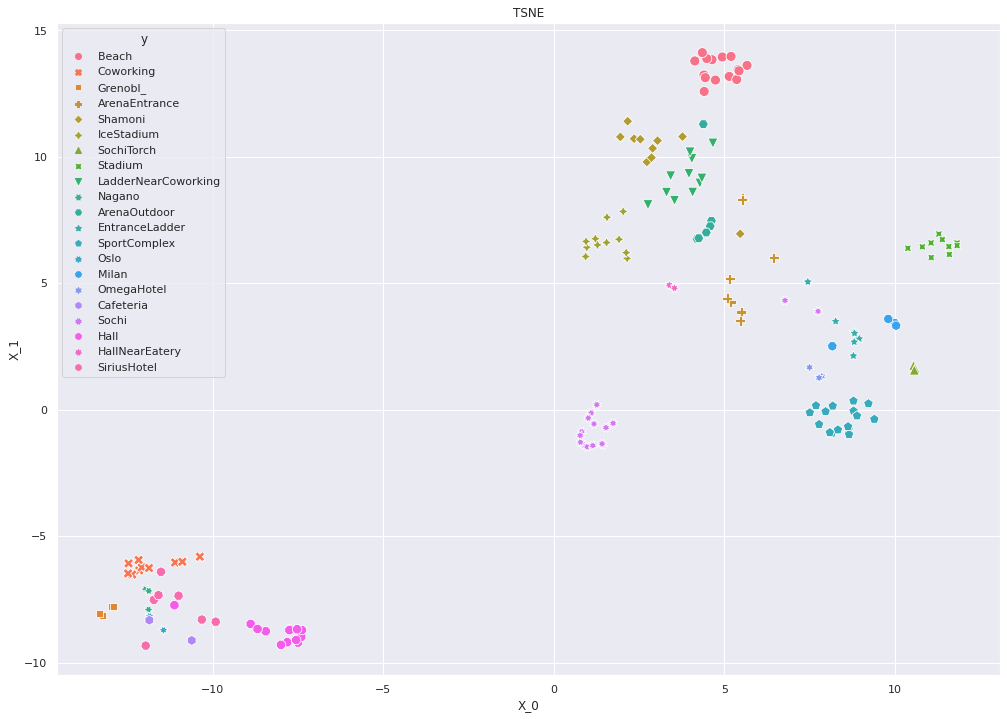

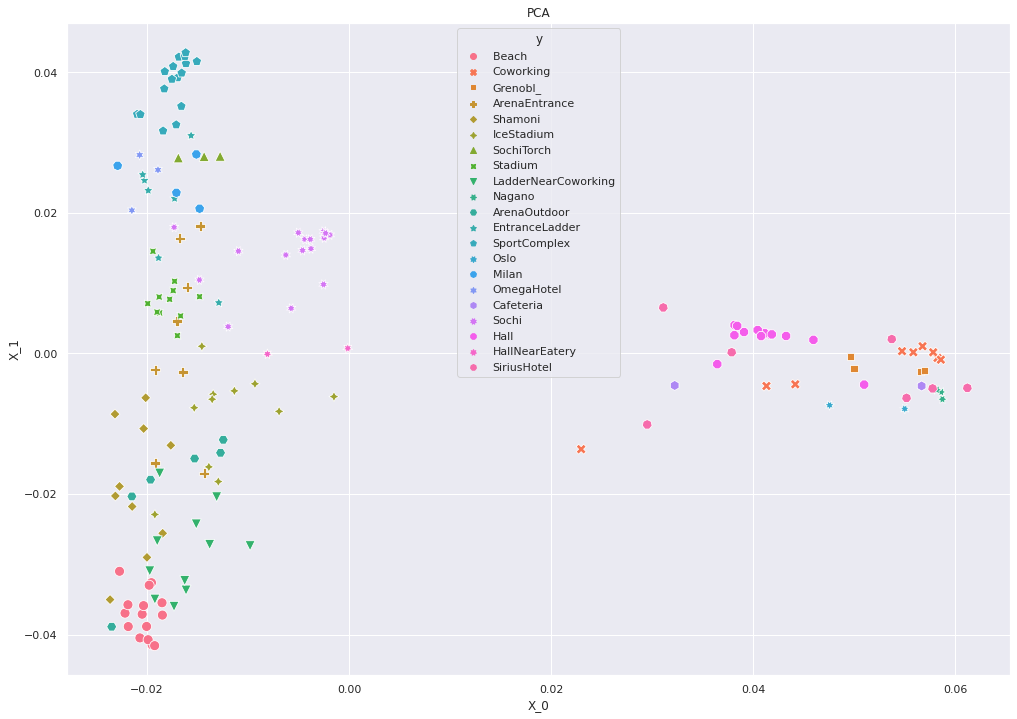

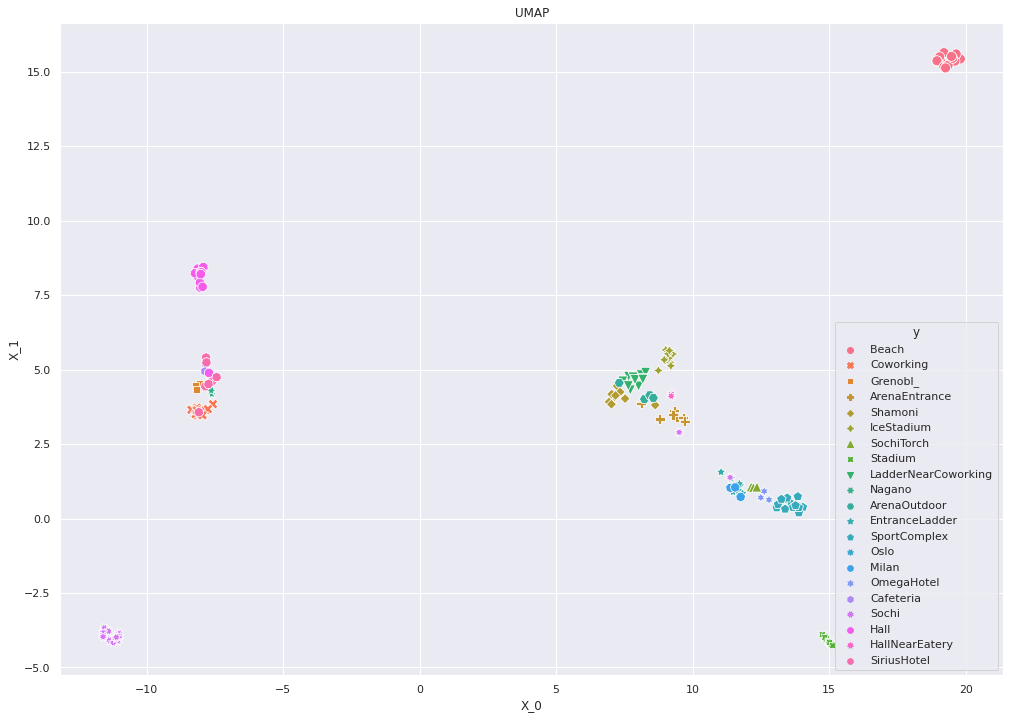

In [63]:


plot_embeddings(X_base, Y_base.numpy(), TSNE, 'TSNE')
plt.show()
plot_embeddings(X_base, Y_base.numpy(), PCA, 'PCA')
plt.show()
plot_embeddings(X_base, Y_base.numpy(), umap.UMAP, 'UMAP')

In [38]:
model.eval()
# валидация
images = []
labels = []
for image, label in test_data_loader:
    out = model(image.cuda()).cpu().detach()
    print(out.shape)
    images.append(out)
    labels.append(label)
images = torch.cat(images, dim=0)

# print(out_train_image.shape)
# break
X_base = images
Y_base = torch.hstack(labels)
metrics_dict = validate(model, X_base, Y_base, valid_data_loader, metric_funcs)
# metrics_dict["triplet_loss"] = loss/len(train_data_loader)

torch.Size([64, 10752])
torch.Size([64, 10752])
torch.Size([36, 10752])


In [39]:
metrics_dict

{'accuracy': 0.9466666666666667,
 'macro_f1_score@k': 0.7415743338831419,
 'macro_precision@k': 0.6408777382461592,
 'macro_recall@k': 0.986441798941799,
 'precision-weighted': 0.9522128851540618,
 'recall': 0.9466666666666667,
 'recall-macro': 0.9378401360544217,
 'recall-micro': 0.9466666666666667,
 'weighted_f1_score@k': 0.8056295589245493,
 'weighted_precision@k': 0.7165044916097547,
 'weighted_recall@k': 0.98}

In [40]:
def backbone_predict(x):
    return base_model(x).view(x.shape[0], -1)

In [41]:
base_model.eval()
# валидация
images = []
labels = []
for image, label in test_data_loader:
    out = backbone_predict(image.cuda()).cpu().detach()
    print(out.shape)
    images.append(out)
    labels.append(label)
images = torch.cat(images, dim=0)

# print(out_train_image.shape)
# break
X_base = images
Y_base = torch.hstack(labels)
metrics_dict = validate(backbone_predict, X_base, Y_base, valid_data_loader, metric_funcs)
# metrics_dict["triplet_loss"] = loss/len(train_data_loader)

torch.Size([64, 8192])
torch.Size([64, 8192])
torch.Size([36, 8192])


In [42]:
metrics_dict

{'accuracy': 0.8866666666666667,
 'macro_f1_score@k': 0.6545181929482873,
 'macro_precision@k': 0.5699140270568842,
 'macro_recall@k': 0.9728707139421425,
 'precision-weighted': 0.9102352941176473,
 'recall': 0.8866666666666667,
 'recall-macro': 0.8944976980691266,
 'recall-micro': 0.8866666666666667,
 'weighted_f1_score@k': 0.7560242508370124,
 'weighted_precision@k': 0.6913492824326158,
 'weighted_recall@k': 0.96}